Our model will use just two LSTMs (one encoder and one decoder) to translate Hungarian to English. We're going with Hungarian here because it's a particularly challenging language to tackle with few resources.
<br><br>
The dataset we'll use comes from **Tatoeba**, a collection of sentence translations in a variety of languages sourced from volunteers:
<br>
https://tatoeba.org/en

In [1]:
import io
import json
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf
import unicodedata

from google.colab import files
from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore")

# Recurrence-based Seq2Seq Neural Machine Translation **WITHOUT** Attention

In [2]:
# Download the training set.
!wget https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_train.txt

--2023-03-28 14:50:15--  https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5518306 (5.3M) [text/plain]
Saving to: ‘hun_eng_pairs_train.txt’

hun_eng_pairs_train 100%[===================>]   5.26M  --.-KB/s    in 0.08s   

2023-03-28 14:50:15 (66.8 MB/s) - ‘hun_eng_pairs_train.txt’ saved [5518306/5518306]



In [3]:
with open('hun_eng_pairs_train.txt') as file:
  train = [line.rstrip() for line in file]

In [4]:
train[:5]

["Teszek rá, mit mondasz!<sep>I don't care what you say.",
 'Több olyan ember kell nekünk a csapatba, mint amilyen te vagy.<sep>We need more people like you on our team.',
 'Vigyázz a gyerekeimre!<sep>Take care of my children.',
 'Miért van szüksége önöknek két kerékpárra?<sep>Why do you need two bicycles?',
 "Nincs helye a kétségnek.<sep>There's no room for doubt."]

In [5]:
len(train)

88647

In [6]:
# Separate the input (Hungarian) and target (English) sentences into separate lists.
SEPARATOR = '<sep>'
train_input, train_target = map(list, zip(*[pair.split(SEPARATOR) for pair in train]))

print(train_input[:5])
print(train_target[:5])

['Teszek rá, mit mondasz!', 'Több olyan ember kell nekünk a csapatba, mint amilyen te vagy.', 'Vigyázz a gyerekeimre!', 'Miért van szüksége önöknek két kerékpárra?', 'Nincs helye a kétségnek.']
["I don't care what you say.", 'We need more people like you on our team.', 'Take care of my children.', 'Why do you need two bicycles?', "There's no room for doubt."]


## Preprocess Train Data

In [7]:
print("\u00E1", "\u0061\u0301") # 2 different charachters 

á á


Here's an informative article on the importance of Unicode normalization and how to go about it (including what _NFD_ means):<br>
https://towardsdatascience.com/what-on-earth-is-unicode-normalization-56c005c55ad0

In [8]:
# Unicode normalization
def normalize_unicode(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn') # Nonspacing_Mark

We're building a **word**-based translation model, but we still want to keep punctuation and treat them as separate tokens, so we'll insert a space between any relevant punctuation and the characters around them. This way, our tokenizer (which won't filter out punctuation) will output punctuation marks as separate tokens.

This function does that and unicode normalization.

In [9]:
def preprocess_sentence(s):
  s = normalize_unicode(s)
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  return s

# Preprocess both the source and target sentences.
train_preprocessed_input = [preprocess_sentence(s) for s in train_input]
train_preprocessed_target = [preprocess_sentence(s) for s in train_target]

# sanity check
train_preprocessed_input[:5]

['Teszek ra , mit mondasz !',
 'Tobb olyan ember kell nekunk a csapatba , mint amilyen te vagy .',
 'Vigyazz a gyerekeimre !',
 'Miert van szuksege onoknek ket kerekparra ?',
 'Nincs helye a ketsegnek .']

In [10]:
# Teacher Forcing 
def tag_target_sentences(sentences):
  tagged_sentences = map(lambda s: (' ').join(['<sos>', s, '<eos>']), sentences)
  return list(tagged_sentences)

train_tagged_preprocessed_target = tag_target_sentences(train_preprocessed_target)

# sanity check
train_tagged_preprocessed_target[:5]

["<sos> I don't care what you say . <eos>",
 '<sos> We need more people like you on our team . <eos>',
 '<sos> Take care of my children . <eos>',
 '<sos> Why do you need two bicycles ? <eos>',
 "<sos> There's no room for doubt . <eos>"]

### Tokenization

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenizer for the Hungarian input sentences. Note how we're not filtering punctuation.
source_tokenizer = Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_preprocessed_input)
train_encoder_inputs = source_tokenizer.texts_to_sequences(train_preprocessed_input)

source_vocab_size = len(source_tokenizer.word_index) + 1
print(source_vocab_size)

38539


In [12]:
# sanity check
print(train_encoder_inputs[:3])
print(source_tokenizer.sequences_to_texts(train_encoder_inputs[:3]))

[[1395, 91, 4, 27, 1080, 10], [153, 56, 145, 17, 152, 3, 7232, 4, 45, 1670, 44, 23, 2], [1026, 3, 8933, 10]]
['teszek ra , mit mondasz !', 'tobb olyan ember kell nekunk a csapatba , mint amilyen te vagy .', 'vigyazz a gyerekeimre !']


In [13]:
# Tokenizer for the English target sentences.
target_tokenizer = Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)

target_vocab_size = len(target_tokenizer.word_index) + 1
print(target_vocab_size)

10556


In [14]:
# inspect special charachters
list(target_tokenizer.word_index)[:5]

['<unk>', '<sos>', '<eos>', '.', 'i']

For **Teacher Forcing**, we'll create two copies of each vectorized **target** sentence, with the second copy shifted over by one.

The function below takes a collection of sentences, vectorizes them, then returns two copies of each. The first will include every token except the last, the second will include every token except the first.

In [15]:
def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs] # Drop the last token in the sentence.
  decoder_targets = [s[1:] for s in seqs] # Drop the first token in the sentence.

  return decoder_inputs, decoder_targets

train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_preprocessed_target, 
                                                                              target_tokenizer)

Each token of a *decoder_input* sentence will be fed to the decoder as the **next** expected token, and each token of a *decoder_target* sentence will be used to calculate the loss against the decoder's actual output.

In [16]:
# sanity check
print(train_decoder_inputs[0], train_decoder_targets[0])

print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:1]), 
      target_tokenizer.sequences_to_texts(train_decoder_targets[:1]))

[2, 5, 23, 306, 28, 7, 151, 4] [5, 23, 306, 28, 7, 151, 4, 3]
["<sos> i don't care what you say ."] ["i don't care what you say . <eos>"]


### Padding

In [17]:
# Hungarian
max_encoding_len = len(max(train_encoder_inputs, key=len))
max_encoding_len

37

In [18]:
# English
max_decoding_len = len(max(train_decoder_inputs, key=len))
max_decoding_len

34

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len,
                                            padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len,
                                            padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len,
                                             padding='post', truncating='post')

# sanity check
print(padded_train_encoder_inputs[0])
print(padded_train_decoder_inputs[0])
print(padded_train_decoder_targets[0])

[1395   91    4   27 1080   10    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[  2   5  23 306  28   7 151   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5  23 306  28   7 151   4   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [20]:
# converting a padded sequence back to text
target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[0]])

["<sos> i don't care what you say . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>"]

## Preprocess Validation Data

In [21]:
# Download validation set pairs.
!wget https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_val.txt

--2023-03-28 14:50:23--  https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_val.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 646226 (631K) [text/plain]
Saving to: ‘hun_eng_pairs_val.txt’

hun_eng_pairs_val.t 100%[===================>] 631.08K  --.-KB/s    in 0.04s   

2023-03-28 14:50:23 (13.9 MB/s) - ‘hun_eng_pairs_val.txt’ saved [646226/646226]



In [22]:
# read data
with open('hun_eng_pairs_val.txt') as file:
  valid = [line.rstrip() for line in file]

In [23]:
def process_dataset(dataset):

  # Split the Hungarian and English sentences into separate lists.
  input, output = map(list, zip(*[pair.split(SEPARATOR) for pair in dataset]))

  # Unicode normalization and inserting spaces around punctuation.
  preprocessed_input = [preprocess_sentence(s) for s in input]
  preprocessed_output = [preprocess_sentence(s) for s in output]

  # Tag target sentences with <sos> and <eos> tokens.
  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  # Vectorize encoder source sentences.
  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  # Vectorize and create decoder input and target sentences.
  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output, 
                                                                    target_tokenizer)
  
  # Pad all collections.
  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', 
                                        truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', 
                                        truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', 
                                         truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [24]:
# Process validation dataset
padded_valid_encoder_inputs, padded_valid_decoder_inputs, padded_valid_decoder_targets = process_dataset(valid)

## Model

This model will have **two** inputs:<br>
1. **The encoder** receives the source sentences (Hungarian) and generates the initial state inputs for the decoder.
2. **The decoder** receives the decoder input sentences (English) for teacher forcing.
<br>


In [25]:
# hyperparameters
class CFG:
  embedding_dim = 128
  rnn_dim = 256
  hidden_dim = 256
  dropout = 0.2
  batch_size = 32
  epochs = 30

The LSTM always returns three values:


When `return_sequences=False` encoder_outputs and state_h are the SAME. When `return_sequences=True` is True, encoder_outputs contains the encoder hidden states from each time step.

In [26]:
# Encoder

# None or max_encoding_len
encoder_inputs = layers.Input(shape=[None], name='encoder_inputs')

encoder_embeddings = layers.Embedding(source_vocab_size, 
                                      CFG.embedding_dim,
                                      mask_zero=True,
                                      name='encoder_embeddings')

encoder_embedding_output = encoder_embeddings(encoder_inputs)

encoder_lstm = layers.LSTM(CFG.rnn_dim, 
                           return_state=True,  # return the last state
                           dropout=CFG.dropout, 
                           name='encoder_lstm')

# we won't be using encoder_outputs here
_, state_h, state_c = encoder_lstm(encoder_embedding_output)
encoder_states = (state_h, state_c)

The code for specifying the decoder is similar except for three additions:
1. The LSTM has *return_sequences* set to *True* since we'll need the hidden state outputted at each timestep.

2. The decoder's LSTM takes an *initial_state*, the value for which is from the encoder.

3. There's a *softmax* layer in the end to generate a probability distribution over the target (English) vocabulary.

In [27]:
# Decoder

# None or max_decoding_len
decoder_inputs = layers.Input(shape=[None], name='decoder_inputs')


decoder_embeddings = layers.Embedding(target_vocab_size, 
                                      CFG.embedding_dim, 
                                      mask_zero=True,
                                      name='decoder_embeddings')


decoder_embedding_output = decoder_embeddings(decoder_inputs)

# Return sequences set to True.
decoder_lstm = layers.LSTM(CFG.rnn_dim,
                           return_sequences=True,
                           return_state=True,
                           dropout=CFG.dropout,
                           name='decoder_lstm')

# using only decoder_outputs here
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

decoder_dense = layers.Dense(target_vocab_size, activation='softmax', name='decoder_dense')

y_proba = decoder_dense(decoder_outputs)

In [28]:
# model
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=y_proba,
                       name='hun_eng_seq2seq_nmt_no_attention')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-5), 
              loss='sparse_categorical_crossentropy',  
              metrics='sparse_categorical_accuracy')
model.summary()

Model: "hun_eng_seq2seq_nmt_no_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embeddings (Embedding)  (None, None, 128)   4932992     ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embeddings (Embedding)  (None, None, 128)   1351168     ['decoder_inputs[0][0]']         
                                                                   

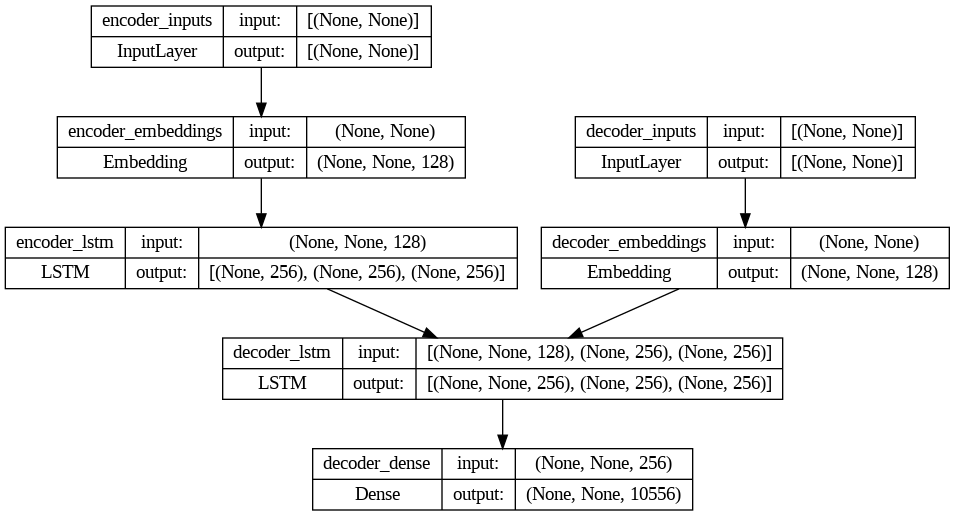

In [29]:
# visualize our model
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [30]:
# Saving this to a folder on my local machine.
filepath="./HunEngNMTNoAttention/training1/cp.ckpt"

# Create a callback that saves the model's weights and early stops 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train model
history = model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs],
                     padded_train_decoder_targets,
                     batch_size=CFG.batch_size,
                     epochs=CFG.epochs,
                     validation_data=([padded_valid_encoder_inputs, padded_valid_decoder_inputs],
                                      padded_valid_decoder_targets),
                     callbacks=[cp_callback, es_callback])

Epoch 1/30
2771/2771 [==============================] - ETA: 0s - loss: 3.8696 - sparse_categorical_accuracy: 0.3769
Epoch 1: saving model to ./HunEngNMTNoAttention/training1/cp.ckpt
2771/2771 [==============================] - 131s 42ms/step - loss: 3.8696 - sparse_categorical_accuracy: 0.3769 - val_loss: 3.1313 - val_sparse_categorical_accuracy: 0.4585
Epoch 2/30
2771/2771 [==============================] - ETA: 0s - loss: 2.7783 - sparse_categorical_accuracy: 0.4975
Epoch 2: saving model to ./HunEngNMTNoAttention/training1/cp.ckpt
2771/2771 [==============================] - 95s 34ms/step - loss: 2.7783 - sparse_categorical_accuracy: 0.4975 - val_loss: 2.5885 - val_sparse_categorical_accuracy: 0.5285
Epoch 3/30
2771/2771 [==============================] - ETA: 0s - loss: 2.2359 - sparse_categorical_accuracy: 0.5648
Epoch 3: saving model to ./HunEngNMTNoAttention/training1/cp.ckpt
2771/2771 [==============================] - 98s 36ms/step - loss: 2.2359 - sparse_categorical_accuracy:

In [31]:
# save the model and tokenizers

###### Save the model.
# model.save('hun_eng_s2s_nmt_no_attention')


###### Zip and download the model.
# !zip -r ./hun_eng_s2s_nmt_no_attention.zip ./hun_eng_s2s_nmt_no_attention
# files.download("./hun_eng_s2s_nmt_no_attention.zip")


###### Save the tokenizers as JSON files. The resulting files can be downloaded by left-clicking on them.
# source_tokenizer_json = source_tokenizer.to_json()
# with io.open('source_tokenizer.json', 'w', encoding='utf-8') as f:
#   f.write(json.dumps(source_tokenizer_json, ensure_ascii=False))

# target_tokenizer_json = target_tokenizer.to_json()
# with io.open('target_tokenizer.json', 'w', encoding='utf-8') as f:
#   f.write(json.dumps(target_tokenizer_json, ensure_ascii=False))

In [32]:
# # load the model and tokenizers
# with open('source_tokenizer.json') as f:
#     data = json.load(f)
#     source_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

# with open('target_tokenizer.json') as f:
#     data = json.load(f)
#     target_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [33]:
# # Load the model.
# model = tf.keras.models.load_model('hun_eng_s2s_nmt_no_attention')

## Evalute model using test data

In [34]:
# Retrieve the test dataset.
!wget https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_test.txt

--2023-03-28 15:11:31--  https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 646226 (631K) [text/plain]
Saving to: ‘hun_eng_pairs_test.txt’

hun_eng_pairs_test. 100%[===================>] 631.08K  --.-KB/s    in 0.04s   

2023-03-28 15:11:31 (14.0 MB/s) - ‘hun_eng_pairs_test.txt’ saved [646226/646226]



In [35]:
with open('hun_eng_pairs_test.txt') as file:
  test = [line.rstrip() for line in file]

test[:5]

['Abbahagyhatom, ha zavar.<sep>If it bothers you, I can stop doing this.',
 'Nős voltam.<sep>I was married.',
 'Ez a zene az idegeire megy.<sep>That music gets on his nerves.',
 "Nem tűnik úgy, hogy egyetértenél.<sep>You don't seem to agree.",
 'Mennyibe kerül?<sep>What does that cost?']

In [36]:
# Preprocess test dataset
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(test)

In [37]:
# Evaluate the model on the test set.
model.evaluate([padded_test_encoder_inputs, padded_test_decoder_inputs], padded_test_decoder_targets)

326/326 [==============================] - 6s 19ms/step - loss: 1.8669 - sparse_categorical_accuracy: 0.6842


[1.8668562173843384, 0.6841802000999451]

## Inference

Our training model uses teacher forcing, but that won't be the case for inference. So we'll take the trained layers from our training model, and create **separate**, stand-alone encoder and decoder models. This will give us much greater control over how the output is created as we'll see. (e.g. feeding the current output as the input to the next time step).

In [38]:
# These are the layers of our trained model.
[layer.name for layer in model.layers]

['encoder_inputs',
 'decoder_inputs',
 'encoder_embeddings',
 'decoder_embeddings',
 'encoder_lstm',
 'decoder_lstm',
 'decoder_dense']

Creating a stand-alone encoder is just a matter of retrieving the trained layers by name and re-creating the graph.

The major difference here is the last line where we're calling *tf.keras.Model* to create a stand-alone encoder with *encoder_inputs* as the input and *encoder_states* as the output.<br>

In [39]:
# stand-alone encoder
encoder_inputs = model.get_layer('encoder_inputs').input
encoder_embedding_layer = model.get_layer('encoder_embeddings')
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = model.get_layer('encoder_lstm')
_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embeddings)
encoder_states = [encoder_state_h, encoder_state_c]

# Our stand-alone encoder model. encoder_inputs is the input to the encoder,
# and encoder_states is the expected output.
encoder_model_no_attention = tf.keras.Model(encoder_inputs, encoder_states)

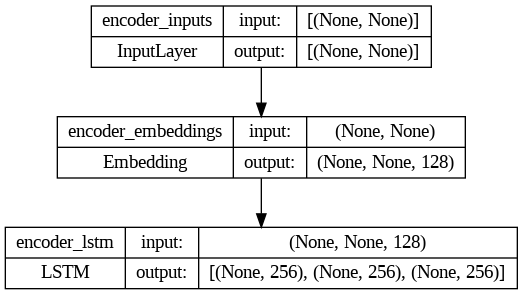

In [40]:
plot_model(encoder_model_no_attention, show_shapes=True, show_layer_names=True)

Creating the decoder is similar. The major difference here is that there are two additional inputs to the decoder representing its LSTM hidden state (*decoder_input_state_h*) and cell state (*decoder_input_state_c*), respectively.
<br><br>
They are there because the encoder and decoder are now separate models, so we'll manually take the encoder's output (its final states) and use them as the decoder's initial state. From there, at each time step, we'll take the decoder's state outputs and feed them to the next time step.
<br><br>
The stand-alone decoder now takes as input:
- Either the '\<sos\>' token (at the beginning) or the output from the previous timestep. Either way, it'll now take only one token at a time.
- Hidden and cell states, either from the encoder initially or from the decoder's last time step.
<br>

And it outputs a probability distribution for the current output, and new hidden and cell states.

In [41]:
decoder_inputs = model.get_layer('decoder_inputs').input
decoder_embedding_layer = model.get_layer('decoder_embeddings')
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

# Inputs to represent the decoder's LSTM hidden and cell states. We'll populate 
# these manually using the encoder's output for the initial state.
decoder_input_state_h = tf.keras.Input(shape=(CFG.rnn_dim, ), name='decoder_input_state_h')
decoder_input_state_c = tf.keras.Input(shape=(CFG.rnn_dim, ), name='decoder_input_state_c')
decoder_input_states = [decoder_input_state_h, decoder_input_state_c]

decoder_lstm = model.get_layer('decoder_lstm')
decoder_sequence_outputs, decoder_output_state_h, decoder_output_state_c = decoder_lstm(
    decoder_embeddings, initial_state=decoder_input_states
    )

# Update hidden and cell states for the next time step.
decoder_output_states = [decoder_output_state_h, decoder_output_state_c]

decoder_dense = model.get_layer('decoder_dense')
y_proba = decoder_dense(decoder_sequence_outputs)

decoder_model_no_attention = tf.keras.Model(
    [decoder_inputs] + decoder_input_states,
    [y_proba] + decoder_output_states
)

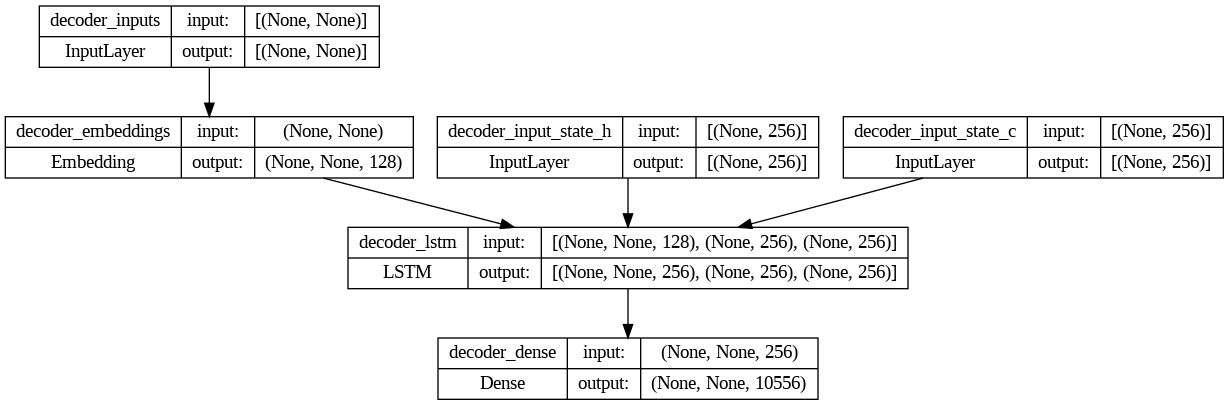

In [42]:
plot_model(decoder_model_no_attention, show_shapes=True, show_layer_names=True)

The method below translates a sentence from the source language to the target language. It encodes the source sentence as usual, then feeds the encoder's state outputs and the \<sos\> token into the decoder.
<br><br>
The decoder's outputs (the resulting word and its hidden/cell states) are then fed back to the decoder at the next time step. This continues until either a max word limit is reached or an \<eos\> token is generated.

In [43]:
def translate_without_attention(sentence: str, 
                                source_tokenizer, encoder,
                                target_tokenizer, decoder,
                                length = 30):

  # Vectorize the source sentence and run it through the encoder.    
  input_seq = source_tokenizer.texts_to_sequences([sentence])

  # Get the tokenized sentence to see if there are any unknown tokens.
  tokenized_sentence = source_tokenizer.sequences_to_texts(input_seq)

  states = encoder.predict(input_seq, verbose=0)  

  current_word = '<sos>'
  decoded_sentence = []

  while len(decoded_sentence) < length:
    
    # Set the next input word for the decoder.
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_tokenizer.word_index[current_word]
    
    # Determine the next word.
    target_y_proba, h, c = decoder.predict([target_seq] + states, verbose=0)
    target_token_index = np.argmax(target_y_proba[0, -1, :])
    current_word = target_tokenizer.index_word[target_token_index]

    if (current_word == '<eos>'):
      break

    decoded_sentence.append(current_word)
    states = [h, c]
  
  return tokenized_sentence[0], ' '.join(decoded_sentence)


In [44]:
# sample a bunch of sentences from the test dataset and translate them
sentences = random.sample(test, 15)
sentences

['Tomi gyakran tesz fahéjat a kávéjába.<sep>Tom often puts cinnamon in his coffee.',
 'Tomit tönkretették.<sep>Tom is ruined.',
 'Hagytam Tomit nyerni.<sep>I let Tom win.',
 'Ők valahol máshol voltak.<sep>They were somewhere else.',
 "Nem engedhetik meg maguknak.<sep>They can't afford it.",
 'Hozd be, Tom!<sep>Bring it in, Tom.',
 'Önnek van valamije, ami nekem kell.<sep>You have something I need.',
 'Tomi egy politikus.<sep>Tom is a politician.',
 'Hiányzik anyu!<sep>I miss my mom.',
 'Fáradtak a szemeim.<sep>My eyes are tired.',
 'Ülj fel a bicajodra!<sep>Get on your bike.',
 'Azt gondolom, hogy Tomi fél tőled.<sep>I think Tom is afraid of you.',
 "Művészi vagy.<sep>You're artistic.",
 'A két férfi egymást okolta a bűncselekményért.<sep>The two men blamed each other for the crime.',
 'Nem tudnak semmit.<sep>They know nothing.']

In [45]:
def translate_sentences(sentences, translation_func,
                        source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for s in sentences:
    source, target = s.split(SEPARATOR)
    source = preprocess_sentence(source)
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)
  
  return translations

In [48]:
from nltk.translate.bleu_score import sentence_bleu

# define the bleu scores function
def calculate_bleu(row):
    """
    Calculates the BLEU score for a candidate sentence
    compared to a reference sentence.
    """
    reference = [row['Reference'].split()]
    candidate = row['Translation'].split()
    return sentence_bleu(reference, candidate)

In [49]:
# load the results into a Pandas DataFrame for easier viewing.
translations_no_attention = pd.DataFrame(translate_sentences(sentences, translate_without_attention,
                                                             source_tokenizer, encoder_model_no_attention,
                                                             target_tokenizer, decoder_model_no_attention))
translations_no_attention['BLEU Score'] = translations_no_attention.apply(calculate_bleu, axis=1)
print(translations_no_attention['BLEU Score'].mean())
translations_no_attention

3.1983981546086295e-79


,Tokenized Original,Reference,Translation,BLEU Score
0,tomi gyakran tesz <unk> a kavejaba .,Tom often puts cinnamon in his coffee.,tom often puts his coffee without his mind .,6.739372e-155
1,tomit tonkretettek .,Tom is ruined.,tom is exhausted .,1.288230e-231
2,hagytam tomit nyerni .,I let Tom win.,i let tom win .,1.218332e-231
3,ok valahol mashol voltak .,They were somewhere else.,they were somewhere else .,8.388266e-155
4,nem engedhetik meg maguknak .,They can't afford it.,it's not clear yet .,0.000000e+00
5,"hozd be , tom !","Bring it in, Tom.","get it , tom .",1.218332e-231
6,"onnek van valamije , ami nekem kell .",You have something I need.,i have to have my important .,1.120041e-231
7,tomi egy politikus .,Tom is a politician.,tom is a thief .,8.388266e-155
8,hianyzik anyu !,I miss my mom.,i envy him .,0.000000e+00
9,faradtak a <unk> .,My eyes are tired.,they all tired .,0.000000e+00


So performance here tends to be mixed with a few translations which are off, a few which match the reference exactly, and a few interesting ones where the translation doesn't match the reference but conveys the same idea. But overall, pretty good.
<br><br>
There are several limitations we're working with:
- Hungarian is a difficult language because of its flexible structure and high expressiveness. The conjugation style leads to several English words often mapping to one word in Hungarian. Even Google Translate tends to have a high error rate with Hungarian.
- This is a small dataset and to build something robust requires much more data. It also isn't very wide and diverse.
- We're using a simple model with one LSTM for the encoder, and one LSTM for the decoder. In contrast, when Google Translate was still fully recurrence-based, it used an eight-layer LSTM for the encoder, and an eight-layer LSTM for the decoder (though in this case, I still think the data is the primary limitation).
- Translation remains a tricky and hard problem. For examples of issues that arise in translation, check out this video from Rasa: https://www.youtube.com/watch?v=94K4LU_Pe8Y.
<br><br>
Still, we managed to get some decent and interesting results with a simple approach. Next, let's learn how to add an attention layer.

# Recurrence-based Seq2Seq Neural Machine Translation **WITH** Luong Attention


This time around, we'll decouple the encoder and decoder from the beginning (i.e. won't have to build separate models for training and inference). And rather than using the **Functional API**, we'll use **subclassing** instead.

Luong Attention = multiplicative (dot product) attention

In the constructor, we declare our layers. The encoder flow remains much the same. The big difference with this encoder:
- Encoder's LSTM layer is that it has *return_sequences* set to *True*. This means the encoder will now output a hidden state at each time step which will be used by the attention mechanism. 
- There is no masking because masks don't flow through custom layers (such as the attention mechanism), so we'll handle the masking ourselves in a custom loss function.

## Encoder

In [50]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_dim):
    super().__init__()

    # No masking here. We'll handle it ourselves.
    self.embedding = layers.Embedding(vocab_size, embedding_dim, 
                                      name='encoder_embedding_layer')
    
    # return_sequences is set to True this time.
    self.lstm = layers.LSTM(rnn_dim,
                            return_sequences=True, 
                            return_state=True,
                            name='encoder_lstm')
  
  def call(self, input):
    embeddings = self.embedding(input)

    # output_seq will hold the encoder's hidden states from each time step.
    output_seq, state_h, state_c = self.lstm(embeddings)
    return output_seq, state_h, state_c

In [51]:
# sanity check
test_encoder = Encoder(source_vocab_size, CFG.embedding_dim, CFG.rnn_dim)

# receive a batch of sequences.
test_encoder_batch = padded_train_encoder_inputs[:3]
print(test_encoder_batch.shape)
test_encoder_batch

(3, 37)


array([[1395,   91,    4,   27, 1080,   10,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 153,   56,  145,   17,  152,    3, 7232,    4,   45, 1670,   44,
          23,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [1026,    3, 8933,   10,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

In [52]:
test_encoder_outputs, state_h, state_c = test_encoder(test_encoder_batch)

print(test_encoder_outputs.shape)
print(state_h.shape)
print(state_c.shape)

(3, 37, 256)
(3, 256)
(3, 256)


## Luong Attention 

Here we are using Global Attention Model



In [53]:
# Sample encoder LSTM output for single sequence of length 4.
encoder_out = tf.constant([[1., 2., 3.],
                           [2., 3., 4.],
                           [3., 4., 5.],
                           [4., 5. ,6.]])

print('encoder_out shape: {}'.format(encoder_out.shape))
print('Number of timesteps: {}'.format(encoder_out.shape[0]))
print('Number of hidden dimensions: {}'.format(encoder_out.shape[1]))

encoder_out shape: (4, 3)
Number of timesteps: 4
Number of hidden dimensions: 3


In [54]:
# Sample decoder LSTM output for a single timestep.
decoder_out = tf.constant([[1., 3., 5.]])

print('decoder_out shape: {}'.format(decoder_out.shape))
print('Number of timesteps: {}'.format(decoder_out.shape[0]))
print('Number of hidden dimensions: {}'.format(decoder_out.shape[1]))

decoder_out shape: (1, 3)
Number of timesteps: 1
Number of hidden dimensions: 3


In [55]:
attention_scores = tf.matmul(decoder_out, encoder_out, transpose_b=True)
print(attention_scores)

tf.Tensor([[22. 31. 40. 49.]], shape=(1, 4), dtype=float32)


In [56]:
attention_weights = tf.keras.activations.softmax(attention_scores, axis=-1)
print(attention_weights)

tf.Tensor([[1.8792968e-12 1.5228101e-08 1.2339458e-04 9.9987662e-01]], shape=(1, 4), dtype=float32)


In [57]:
context = tf.matmul(attention_weights, encoder_out)
print(context)

tf.Tensor([[3.9998767 4.9998765 5.999877 ]], shape=(1, 3), dtype=float32)


The attention class below follows the same steps. The only difference is the encoder outputs go through a dense layer first.
<br><br>
For input, the attention class takes in all the encoder hidden states and the current decoder hidden state. For output, it returns the attention weights (which could be useful for other purposes) and the context vector.

In [58]:
class LuongAttention(tf.keras.Model):
  def __init__(self, hidden_dim):
    super().__init__()
    self.w = layers.Dense(hidden_dim, name='encoder_outputs_dense')

  def call(self, inputs):
    encoder_output_seq, decoder_output = inputs
    z = self.w(encoder_output_seq)

    attention_scores = tf.matmul(decoder_output, z, transpose_b=True)
    attention_weights = tf.keras.activations.softmax(attention_scores, axis=-1)
    context = tf.matmul(attention_weights, encoder_output_seq)

    return attention_weights, context

## Decoder

The decoder remains mostly the same except:
1. The embedding layer doesn't have masking.
2. There's an additional attention step in the flow.
3. The combined context and decoder output vector goes through a dense layer *w*. 
4. The final dense layer has no softmax activation. Rather, we'll calculate the loss directly on the logits.
<br>

For inputs, the decoder receives:
1. the token(s) for the current step.
  - During training with teacher forcing, that would be the next expected token(s). 
  - During inference, that would be the token(s) generated from the last time step.
2. all the encoder's hidden states.
3. whatever the decoder should take as its current hidden and cell states.
<br>

For outputs, the decoder returns the:
1. logits.
2. last LSTM hidden and cell states.
3. attention weights.

In [59]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_dim, hidden_dim):
    super().__init__()

    self.embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name='decoder_embedding_layer')
    self.lstm = layers.LSTM(rnn_dim, 
                            return_sequences=True,
                            return_state=True,
                            name='decoder_lstm')
    
    self.attention = LuongAttention(hidden_dim)

    self.w = layers.Dense(hidden_dim, activation='tanh', name='attended_outputs_dense')

    self.dense = layers.Dense(vocab_size, name='decoder_dense') # output
    
  def call(self, inputs):
    decoder_input, encoder_output_seq, lstm_state = inputs
    embeddings = self.embedding(decoder_input)

    decoder_output, state_h, state_c = self.lstm(embeddings, initial_state=lstm_state)

    weights, context = self.attention([encoder_output_seq, decoder_output])

    decoder_output_with_attention = self.w(
        tf.concat([tf.squeeze(context, 1), tf.squeeze(decoder_output, 1)], -1)
    )

    logits = self.dense(decoder_output_with_attention)

    return logits, state_h, state_c, weights

In [60]:
# sanity check
test_decoder = Decoder(target_vocab_size, CFG.embedding_dim, CFG.rnn_dim, CFG.hidden_dim)

# receive a batch of sequences.
test_decoder_batch = padded_train_decoder_inputs[:3]
print(test_decoder_batch.shape)
test_decoder_batch

(3, 34)


array([[  2,   5,  23, 306,  28,   7, 151,   4,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  25,  55, 117, 144,  33,   7,  35, 139, 794,   4,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  2, 105, 306,  17,  24, 225,   4,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [61]:
# ...and let's say we're currently on the second timestep (index 1)
test_decoder_batch[:, 1]

array([  5,  25, 105], dtype=int32)

In [62]:
# modify this to be three sequences
next_decoder_inputs = tf.expand_dims(test_decoder_batch[:, 1], 1)
next_decoder_inputs

<tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[  5],
       [ 25],
       [105]], dtype=int32)>

In [63]:
# Initial values for state_h and state_c are from the encoder.
test_decoder_logits, state_h, state_c, test_decoder_weights = test_decoder(
    [
      next_decoder_inputs,
      test_encoder_outputs,
      [state_h, state_c]
    ])

print(test_decoder_logits.shape)
print(test_decoder_weights.shape)

(3, 10556)
(3, 1, 37)


We're going to use a custom loss function because our sequences contain padding, and we don't want predictions on padding to contribute to the loss.
<br><br>
This custom loss function is simply a wrapper around a **sparse categorical crossentropy** loss, but with a mask of 1s and 0s. Any target element of 0 (i.e. a padding value) will get a mask value of 0, everything else will get a mask of 1, and only target values corresponding to a mask value of 1 will be used for loss calculation.

In [64]:
def loss_func(targets, logits):
  ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  mask = tf.cast(tf.math.not_equal(targets, 0), tf.float32)
  
  return ce_loss(targets, logits, sample_weight=mask)

In [65]:
# We'll use Tensorflow's Dataset to batch our data
dataset = tf.data.Dataset.from_tensor_slices((padded_train_encoder_inputs, 
                                              padded_train_decoder_inputs, 
                                              padded_train_decoder_targets)).batch(CFG.batch_size,
                                                                                   drop_remainder=True).prefetch(10_000)

Finally, this is our training function. It'll be called for each batch of data.
<br><br>
*train_step* doesn't have to be in a class, but by putting it inside a *Model* subclass, we can leverage the *fit* method rather than writing our own training loop.
<br><br>
*train_step* is an overridden method called by the *fit* method.<br>
https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
<br><br>
Any operation within the _GradientTape_ context is recorded, and the variables involved are watched. We can then have Tensorflow's autodiff calculate the gradients of the variables with respect to the loss, and backpropagate it through the operations involved.
https://www.tensorflow.org/api_docs/python/tf/GradientTape<br>
https://www.tensorflow.org/guide/autodiff
<br><br>
*train_step* is wrapped in a *@tf.function* annotation for a bit of a performance boost.<br>
https://www.tensorflow.org/api_docs/python/tf/function<br>
https://www.tensorflow.org/guide/function<br>


In [66]:
class TranslatorTrainer(tf.keras.Model):
  def __init__(self, encoder, decoder):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder

  @tf.function
  def train_step(self, inputs):
    loss = 0.0

    encoder_input_seq, decoder_input_seq, decoder_target_seq = inputs

    with tf.GradientTape() as tape:
      encoder_output_seq, state_h, state_c = self.encoder(encoder_input_seq)

      # We need to create a loop to iterate through the target sequences
      for i in range(decoder_target_seq.shape[1]):

        # Input to the decoder must have shape of (batch_size, length)
        # so we need to expand one dimension (just like in the previous example).
        next_decoder_input = tf.expand_dims(decoder_input_seq[:, i], 1)
        logits, state_h, state_c, _ = self.decoder([
            next_decoder_input, encoder_output_seq, (state_h, state_c)
        ])

        # The loss is now accumulated through the whole batch
        loss += self.loss(decoder_target_seq[:, i], logits)
      
    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    return {'loss': loss / decoder_target_seq.shape[1]}

In [67]:
encoder = Encoder(source_vocab_size, CFG.embedding_dim, CFG.rnn_dim)
decoder = Decoder(target_vocab_size, CFG.embedding_dim, CFG.rnn_dim, CFG.hidden_dim)
optimizer = tf.keras.optimizers.Adam()

translator_trainer = TranslatorTrainer(encoder, decoder)
translator_trainer.compile(optimizer=optimizer, loss=loss_func)

In [68]:
epochs = 13 # same as the above model
translator_trainer.fit(dataset, epochs=epochs)

Epoch 1/13
2770/2770 [==============================] - 247s 72ms/step - loss: 0.8569
Epoch 2/13
2770/2770 [==============================] - 197s 71ms/step - loss: 0.5826
Epoch 3/13
2770/2770 [==============================] - 209s 75ms/step - loss: 0.4302
Epoch 4/13
2770/2770 [==============================] - 208s 75ms/step - loss: 0.3225
Epoch 5/13
2770/2770 [==============================] - 206s 74ms/step - loss: 0.2464
Epoch 6/13
2770/2770 [==============================] - 197s 71ms/step - loss: 0.1920
Epoch 7/13
2770/2770 [==============================] - 184s 67ms/step - loss: 0.1528
Epoch 8/13
2770/2770 [==============================] - 188s 68ms/step - loss: 0.1237
Epoch 9/13
2770/2770 [==============================] - 187s 68ms/step - loss: 0.1024
Epoch 10/13
2770/2770 [==============================] - 183s 66ms/step - loss: 0.0866
Epoch 11/13
2770/2770 [==============================] - 187s 68ms/step - loss: 0.0739
Epoch 12/13
2770/2770 [=============================

In [ ]:
# encoder.save_weights('attention_encoder_weights_with_dropout_ckpt')
# decoder.save_weights('attention_decoder_weights_with_dropout_ckpt')

# !zip -r ./attention_weights.zip ./attention_weights

# files.download('./attention_weights.zip')

In [ ]:
# encoder.load_weights('attention_weights/attention_encoder_weights_ckpt')
# decoder.load_weights('attention_weights/attention_decoder_weights_ckpt')

## Inference

The *translate_with_attention* method is similar to the method without attention, except it involves padding since the LSTMs didn't use masking, and also using the encoder's hidden states.

In [69]:
def translate_with_attention(sentence: str, 
                            source_tokenizer, encoder,
                            target_tokenizer, decoder,
                            length = 30):
  input_seq = source_tokenizer.texts_to_sequences([sentence])
  tokenized = source_tokenizer.sequences_to_texts(input_seq)

  input_seq = pad_sequences(input_seq, maxlen=max_encoding_len, 
                            padding='post', truncating='post')
  encoder_output, state_h, state_c = encoder.predict(input_seq, verbose=0)

  current_word = '<sos>'
  decoded_sentence = []

  while len(decoded_sentence) < length:
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_tokenizer.word_index[current_word]

    logits, state_h, state_c, _ = decoder.predict([
        target_seq, encoder_output, (state_h, state_c)
    ], verbose=0)
    current_token_index = np.argmax(logits[0])

    current_word = target_tokenizer.index_word[current_token_index]

    if (current_word == '<eos>'):
      break
    
    decoded_sentence.append(current_word)

  return tokenized[0], ' '.join(decoded_sentence)

We'll translate the same randomly sampled sentences from before and compare the results against the translations without attention.

In [70]:
shorter_translations_w_attention = pd.DataFrame(translate_sentences(sentences, translate_with_attention,
                                                                    source_tokenizer, encoder,
                                                                    target_tokenizer, decoder))
shorter_translations_w_attention['Attention BLEU Score'] = shorter_translations_w_attention.apply(calculate_bleu, axis=1)
shorter_translations_w_attention.rename(columns={'Translation': 'Translation W/ Attention'}, inplace=True)

In [71]:
# add without attention translations
shorter_translations_w_attention['Translation W/O Attention'] = translations_no_attention['Translation']
shorter_translations_w_attention['No Attention BLEU Score'] = translations_no_attention['BLEU Score']

print(shorter_translations_w_attention['Attention BLEU Score'].mean())
shorter_translations_w_attention

1.7193541145438552e-155


,Tokenized Original,Reference,Translation W/ Attention,Attention BLEU Score,Translation W/O Attention,No Attention BLEU Score
0,tomi gyakran tesz <unk> a kavejaba .,Tom often puts cinnamon in his coffee.,tom often asks for his coffee .,1.331960e-231,tom often puts his coffee without his mind .,6.739372e-155
1,tomit tonkretettek .,Tom is ruined.,tom is shocked .,1.288230e-231,tom is exhausted .,1.288230e-231
2,hagytam tomit nyerni .,I let Tom win.,i let tom win .,1.218332e-231,i let tom win .,1.218332e-231
3,ok valahol mashol voltak .,They were somewhere else.,they're ignored somewhere else .,1.218332e-231,they were somewhere else .,8.388266e-155
4,nem engedhetik meg maguknak .,They can't afford it.,he can't afford this .,8.388266e-155,it's not clear yet .,0.000000e+00
5,"hozd be , tom !","Bring it in, Tom.","do , tom , it's tom .",0.000000e+00,"get it , tom .",1.218332e-231
6,"onnek van valamije , ami nekem kell .",You have something I need.,i have more money .,1.218332e-231,i have to have my important .,1.120041e-231
7,tomi egy politikus .,Tom is a politician.,tom is a lawyer .,8.388266e-155,tom is a thief .,8.388266e-155
8,hianyzik anyu !,I miss my mom.,miss your wife .,1.288230e-231,i envy him .,0.000000e+00
9,faradtak a <unk> .,My eyes are tired.,he's tired of the long .,0.000000e+00,they all tired .,0.000000e+00


Ok, so clearly the encoder/decoder with attention gets further along before losing signal and it often manages to translate words later in the sentence.<br><br>
But still, there are clear limitiations. For one thing, we need *much* more data. For another, most industrial translation systems use more complex models. For example, Google's NMT system (when it was based entirely on LSTMs) used 8 layers for both the encoder and decoder.<br><br>
But beyond that, we can use a more powerful model such as Transformers.